In [2]:
pip install transformers PyPDF2 python-docx matplotlib scikit-learn seaborn torch numpy

  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached python_docx-1.2.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.11.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached safetensors-0.7.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached lxml-6.0.2-cp311-cp311-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl.metadata (3.6 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
Using cached python_docx-1.2.0-py3-none-any.whl (252 kB)
Using c

In [3]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
import csv
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / "oc_mini"

# Add dcat package to path
sys.path.insert(0, str(BASE_DIR / "cat-dcat" / "dcat"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load tree and metadata
tree_path = DATA_DIR / "clustering" / "disjoint" / "oc_mini_clusters_0.001.csv"
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"

cluster_df = pd.read_csv(tree_path)

metadata_df = pd.read_csv(metadata_path)
print(f"Loaded cluster data: {cluster_df.shape[0]} nodes")
print(f"\nFirst few rows:")
print(cluster_df.head(10))

print(f"\nCluster statistics:")
print(f"  - Total unique nodes: {cluster_df['node'].nunique()}")
print(f"  - Total unique clusters: {cluster_df['cluster'].nunique()}")
print(f"\nCluster size distribution:")
cluster_sizes = cluster_df['cluster'].value_counts()
print(f"  - Mean cluster size: {cluster_sizes.mean():.2f}")
print(f"  - Median cluster size: {cluster_sizes.median():.0f}")
print(f"  - Largest cluster: {cluster_sizes.max()} nodes")
print(f"  - Smallest cluster: {cluster_sizes.min()} nodes")

print(f"\nCluster assignments loaded!")
#print(f"Tree data loaded: {tree_data['num_nodes']} nodes")
print(f"Metadata loaded: {len(metadata_df)} entries")
metadata_df.head()

Loaded cluster data: 19705 nodes

First few rows:
      node  cluster
0    45066        5
1   989648        0
2  1146632        0
3  3732252        0
4  9488729        5
5  9489474        5
6  9489060        5
7  6382148        5
8  6382959        5
9  1623959        5

Cluster statistics:
  - Total unique nodes: 19705
  - Total unique clusters: 5

Cluster size distribution:
  - Mean cluster size: 3941.00
  - Median cluster size: 2480
  - Largest cluster: 8989 nodes
  - Smallest cluster: 2068 nodes

Cluster assignments loaded!
Metadata loaded: 14442 entries


,id,doi,title,abstract
0,128,10.1101/2021.05.10.443415,Improved protein contact prediction using dime...,AbstractDeep residual learning has shown great...
1,163,10.1101/2021.05.07.443114,Following the Trail of One Million Genomes: Fo...,AbstractSevere acute respiratory syndrome coro...
2,200,10.1101/2021.05.11.443555,Mechanism of molnupiravir-induced SARS-CoV-2 m...,Molnupiravir is an orally available antiviral ...
3,941,10.3390/ijms20020449,Bactericidal and Cytotoxic Properties of Silve...,Silver nanoparticles (AgNPs) can be synthesize...
4,1141,10.3390/ijms20040865,Silver Nanoparticles: Synthesis and Applicatio...,"Over the past few decades, metal nanoparticles..."


In [3]:
from train import train_model

# Train model with adaptive margin triplet loss
finetuned_model, tokenizer, history = train_model(
    tree_json_path=str(tree_path),
    metadata_csv_path=str(metadata_path),
    output_dir=str(BASE_DIR / "cat-hcat" / "models" / "finetuned_adaptive_margin"),
    model_name='allenai/scibert_scivocab_uncased',
    device=str(device),
    batch_size=16,
    epochs=3,
    lr=1e-5,
    base_margin=0.5,        # Base triplet margin
    distance_scale=0.05,     # KEY: Scale margin by tree distance
    samples_per_leaf=3,     # ~43K triplets for 14K leaves
    pooling='cls',
    sampling_strategy='hierarchical'
)

Using device: cuda

Loading tree from /home/vikramr2/oc_mini/clustering/hierarchical/oc_mini_paris.json...
  Leaves: 14384
  Total nodes: 28767
  Max depth: 25

Loading metadata from /home/vikramr2/oc_mini/metadata/oc_mini_node_metadata.csv...
  Entries: 14442

Loading model: allenai/scibert_scivocab_uncased...

Creating dataset...


Generating triplets: 100%|██████████| 14384/14384 [32:19<00:00,  7.42it/s]


  Generated 43152 triplets
  Train: 38836 | Val: 4316

Loss: AdaptiveMarginTripletLoss
  Base margin: 0.5
  Distance scale: 0.05

Starting training for 3 epochs

Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [37:48<00:00,  1.07it/s, loss=0.0000]


  Train loss: 0.1371


Evaluating: 100%|██████████| 270/270 [01:30<00:00,  3.00it/s]


  Val loss: 0.0088
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin...

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [37:47<00:00,  1.07it/s, loss=0.0000]


  Train loss: 0.0132


Evaluating: 100%|██████████| 270/270 [01:29<00:00,  3.01it/s]


  Val loss: 0.0080
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin...

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [37:48<00:00,  1.07it/s, loss=0.0047]


  Train loss: 0.0079


Evaluating: 100%|██████████| 270/270 [01:29<00:00,  3.01it/s]


  Val loss: 0.0063
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin...

Training complete!
  Best val loss: 0.0063
  Model saved to: /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin


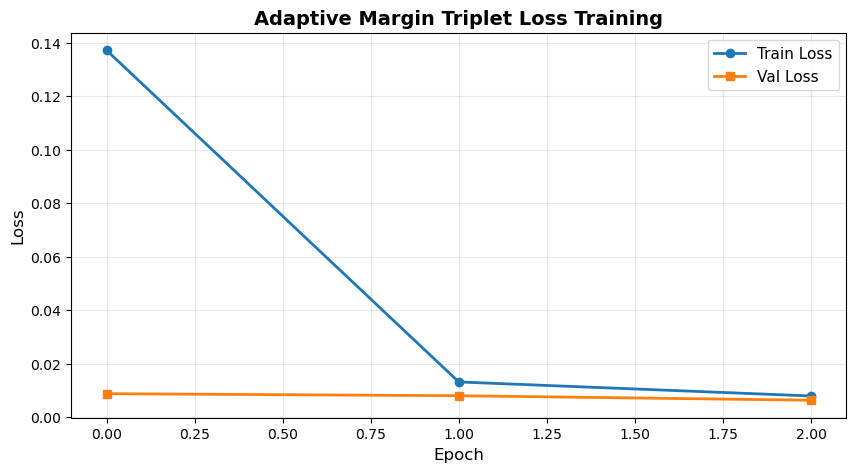


Final train loss: 0.0079
Final val loss: 0.0063


In [4]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], marker='o', label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], marker='s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Adaptive Margin Triplet Loss Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")


In [4]:
from notebook_utils import compute_embeddings

# Load the BEST saved model (not the final epoch model)
output_dir = BASE_DIR / "cat-hcat" / "models" / "finetuned_adaptive_margin"

print("Loading best saved model...")
best_tokenizer = AutoTokenizer.from_pretrained(str(output_dir))
best_model = AutoModel.from_pretrained(str(output_dir)).to(device)
best_model.eval()

print(f"✓ Loaded best model from: {output_dir}")

# Compute embeddings for all nodes using BEST model
print("\nComputing embeddings with best model...")
embeddings_dict = compute_embeddings(
    best_model,  # Use BEST saved model
    best_tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Computed embeddings for {len(embeddings_dict)} nodes")

Loading best saved model...
✓ Loaded best model from: /home/vikramr2/cat-hcat/models/finetuned_adaptive_margin

Computing embeddings with best model...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Computed embeddings for 14442 nodes


In [5]:
from notebook_utils import create_test_split

all_node_ids = list(embeddings_dict.keys())
test_nodes = create_test_split(all_node_ids, test_ratio=0.1, seed=42)

print(f"Test set: {len(test_nodes)} nodes ({len(test_nodes)/len(all_node_ids)*100:.1f}%)")

Test set: 1444 nodes (10.0%)



NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0343
    Precision Normalized@5: 0.0349
    Recall@5: 0.0145
    Hit Rate@5: 0.1445
  K=10:
    Precision@10: 0.0286
    Precision Normalized@10: 0.0337
    Recall@10: 0.0233
    Hit Rate@10: 0.2120
  K=20:
    Precision@20: 0.0220
    Precision Normalized@20: 0.0390
    Recall@20: 0.0355
    Hit Rate@20: 0.2953
  K=50:
    Precision@50: 0.0163
    Precision Normalized@50: 0.0664
    Recall@50: 0.0654
    Hit Rate@50: 0.4510
  K=100:
    Precision@100: 0.0128
    Precision Normalized@100: 0.1003
    Recall@100: 0.0999
    Hit Rate@100: 0.5719

AUC Metrics:
  AUC-ROC: 0.8037
  AUC-PR: 0.2898



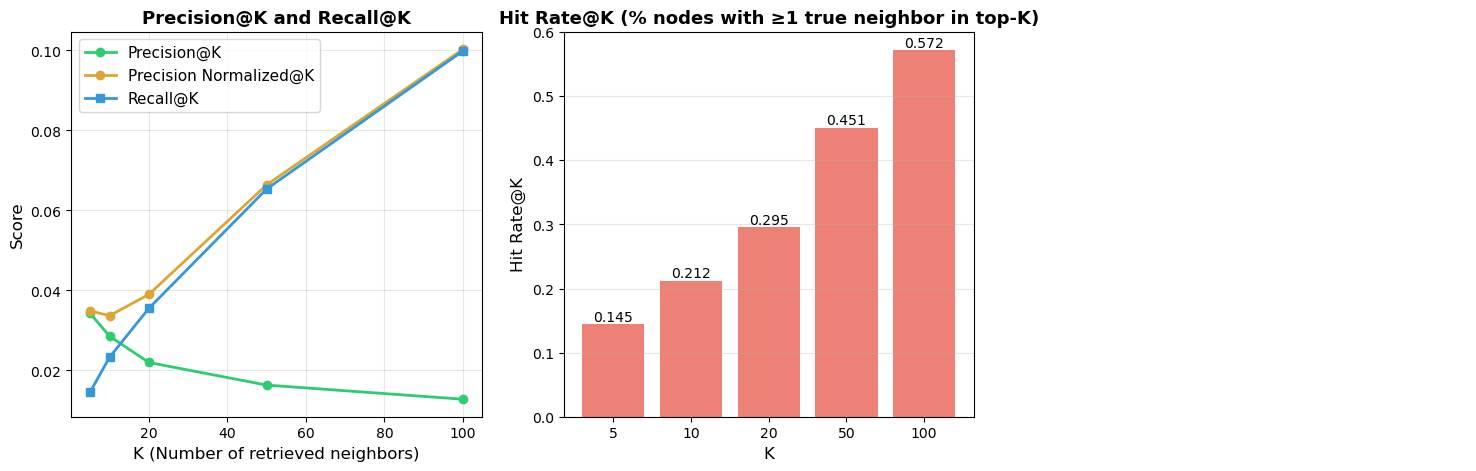

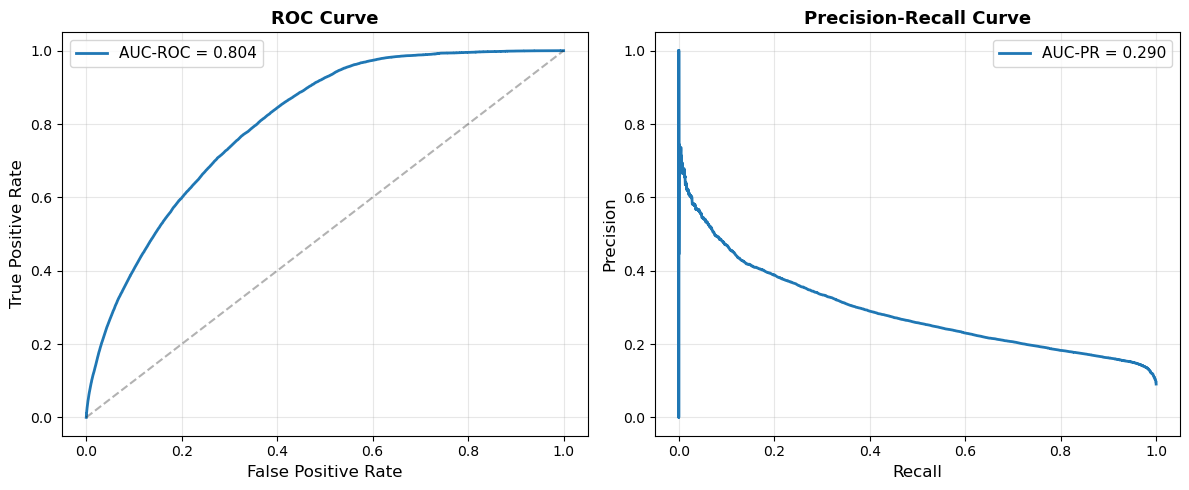

<Figure size 640x480 with 0 Axes>

In [13]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat" / "utils" / "evaluation"))

from link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results
)

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Evaluate fine-tuned model
results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(results['topk'], results['auc'])

In [6]:
# Load baseline SciBERT (not fine-tuned)
print("Loading baseline model...")
baseline_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased").to(device)
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Compute baseline embeddings
print("Computing baseline embeddings...")
baseline_embeddings = compute_embeddings(
    baseline_model,
    tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Baseline embeddings: {len(baseline_embeddings)} nodes")

Loading baseline model...
Computing baseline embeddings...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Baseline embeddings: 14442 nodes


In [14]:
# Evaluate baseline
print("Evaluating baseline...")
baseline_results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=baseline_embeddings,
    test_nodes=test_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

Evaluating baseline...

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0257
    Precision Normalized@5: 0.0262
    Recall@5: 0.0109
    Hit Rate@5: 0.1119
  K=10:
    Precision@10: 0.0202
    Precision Normalized@10: 0.0236
    Recall@10: 0.0158
    Hit Rate@10: 0.1564
  K=20:
    Precision@20: 0.0161
    Precision Normalized@20: 0.0289
    Recall@20: 0.0262
    Hit Rate@20: 0.2314
  K=50:
    Precision@50: 0.0121
    Precision Normalized@50: 0.0485
    Recall@50: 0.0479
    Hit Rate@50: 0.3746
  K=100:
    Precision@100: 0.0093
    Precision Normalized@100: 0.0777
    Recall@100: 0.0774
    Hit Rate@100: 0.4920

AUC Metrics:
  AUC-ROC: 0.6563
  AUC-PR: 0.2090




PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)
  K  Baseline Precision  Fine-tuned Precision  Improvement  Improvement %
  5            0.025712              0.034329     0.008617      33.513514
 10            0.020153              0.028562     0.008409      41.724138
 20            0.016088              0.021994     0.005907      36.717063
 50            0.012106              0.016345     0.004239      35.017222
100            0.009347              0.012808     0.003461      37.026022

AUC METRICS
Baseline AUC-ROC:    0.6563
Fine-tuned AUC-ROC:  0.8037
Improvement:         0.1474 (22.5%)

Baseline AUC-PR:     0.2090
Fine-tuned AUC-PR:   0.2898
Improvement:         0.0807 (38.6%)


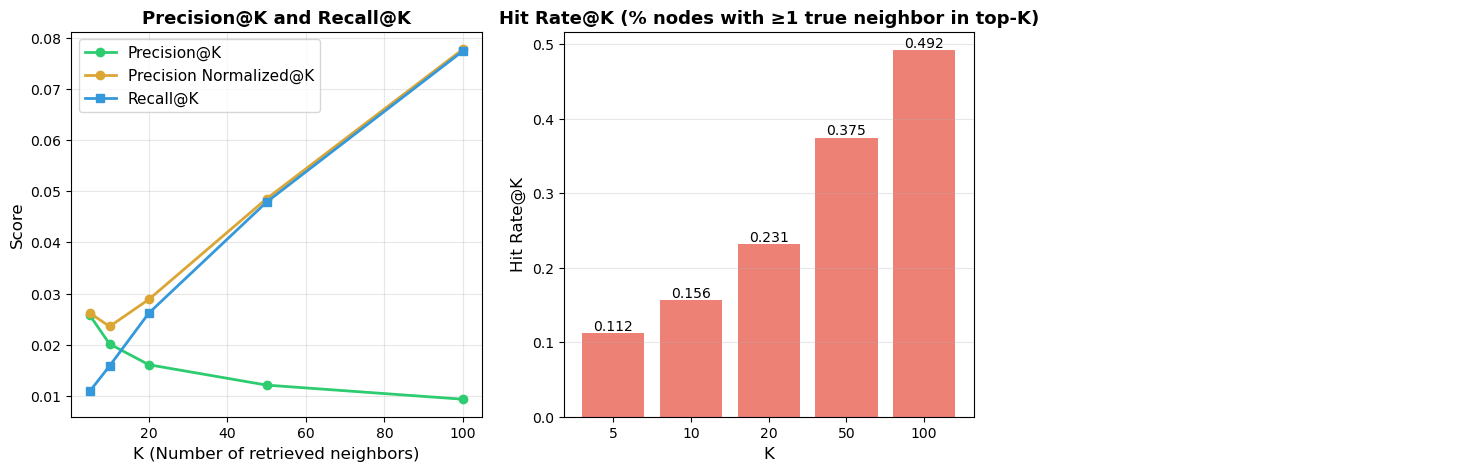

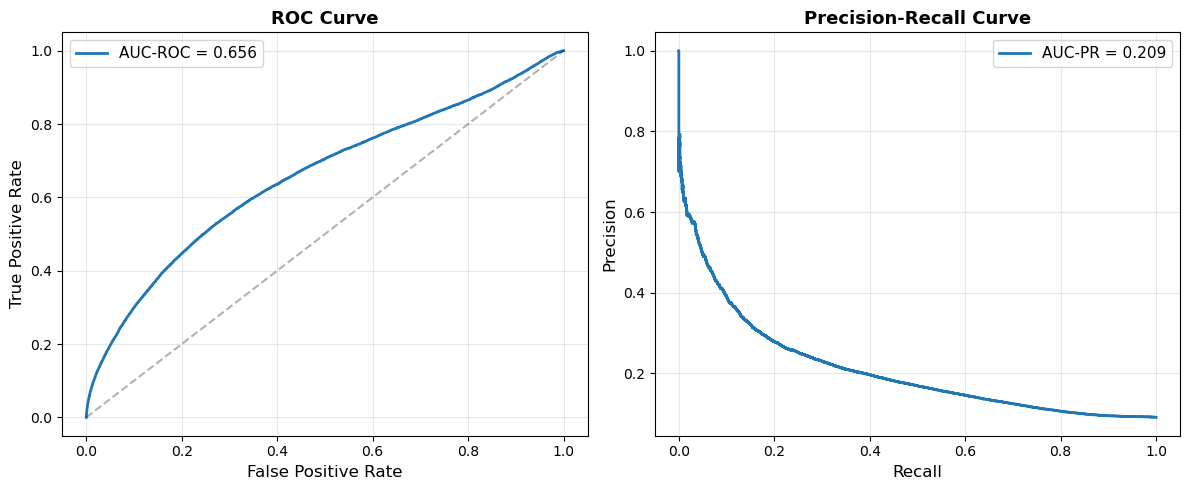

<Figure size 640x480 with 0 Axes>

In [15]:
# Create comparison table
k_values = [5, 10, 20, 50, 100]
comparison_data = []

for k in k_values:
    baseline_prec = baseline_results['topk']['summary'][k]['precision@k']
    finetuned_prec = results['topk']['summary'][k]['precision@k']

    comparison_data.append({
        'K': k,
        'Baseline Precision': baseline_prec,
        'Fine-tuned Precision': finetuned_prec,
        'Improvement': finetuned_prec - baseline_prec,
        'Improvement %': ((finetuned_prec - baseline_prec) / baseline_prec) * 100
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)")
print("="*80)
print(comparison_df.to_string(index=False))

# AUC comparison
print("\n" + "="*80)
print("AUC METRICS")
print("="*80)
print(f"Baseline AUC-ROC:    {baseline_results['auc']['auc_roc']:.4f}")
print(f"Fine-tuned AUC-ROC:  {results['auc']['auc_roc']:.4f}")
print(f"Improvement:         {results['auc']['auc_roc'] - baseline_results['auc']['auc_roc']:.4f} " +
      f"({((results['auc']['auc_roc'] - baseline_results['auc']['auc_roc'])/baseline_results['auc']['auc_roc'])*100:.1f}%)")
print()
print(f"Baseline AUC-PR:     {baseline_results['auc']['auc_pr']:.4f}")
print(f"Fine-tuned AUC-PR:   {results['auc']['auc_pr']:.4f}")
print(f"Improvement:         {results['auc']['auc_pr'] - baseline_results['auc']['auc_pr']:.4f} " +
      f"({((results['auc']['auc_pr'] - baseline_results['auc']['auc_pr'])/baseline_results['auc']['auc_pr'])*100:.1f}%)")

# Visualize
plot_link_prediction_results(baseline_results['topk'], baseline_results['auc'])

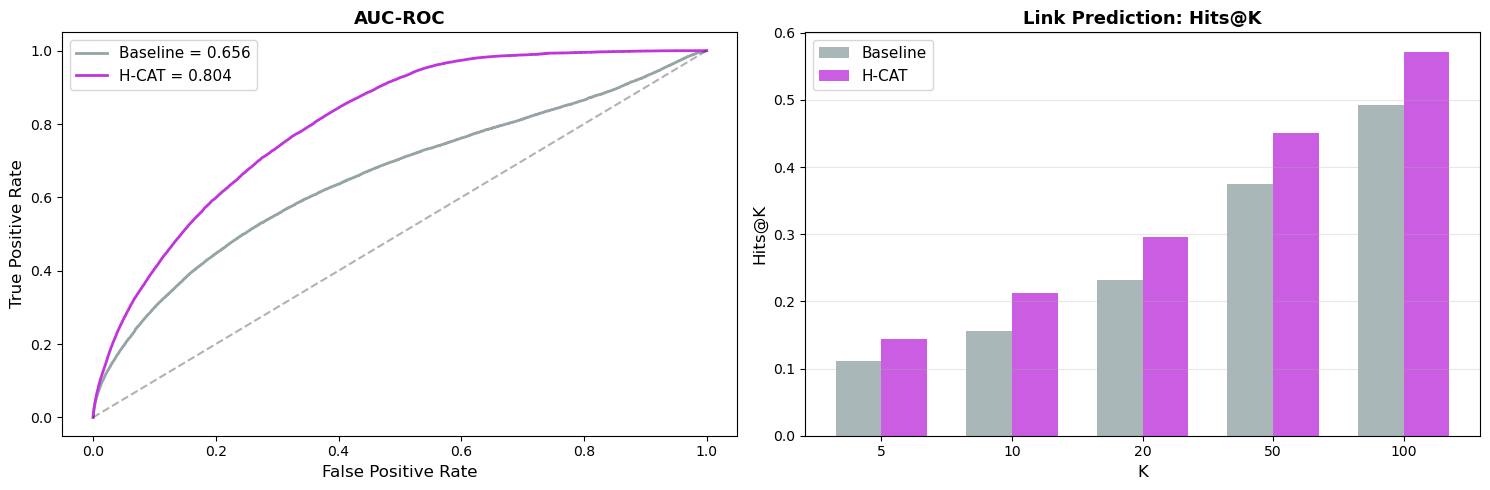

In [21]:
from sklearn.metrics import roc_curve

# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AUC-ROC
ax = axes[0]

fpr, tpr, _ = roc_curve(results['auc']['y_true'], results['auc']['y_scores'])
baseline_fpr, baseline_tpr, _ = roc_curve(results['auc']['y_true'], baseline_results['auc']['y_scores'])

ax.plot(baseline_fpr, baseline_tpr, linewidth=2, label=f"Baseline = {baseline_results['auc']['auc_roc']:.3f}", color='#95a5a6')
ax.plot(fpr, tpr, linewidth=2, label=f"H-CAT = {results['auc']['auc_roc']:.3f}", color='#bf34db')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('AUC-ROC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)

# Hit Rate @ K
ax = axes[1]
x = np.arange(len(k_values))
width = 0.35

baseline_prec = [baseline_results['topk']['summary'][k]['hit_rate@k'] for k in k_values]
finetuned_prec = [results['topk']['summary'][k]['hit_rate@k'] for k in k_values]

bars1 = ax.bar(x - width/2, baseline_prec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_prec, width, label='H-CAT', alpha=0.8, color='#bf34db')

ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Hits@K', fontsize=12)
ax.set_title('Link Prediction: Hits@K', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
import pickle

# Save comparison
results_dir = BASE_DIR / "cat-hcat" / "hcat" / "experiments" / "results"
results_dir.mkdir(exist_ok=True, parents=True)

comparison_df.to_csv(results_dir / "link_prediction_comparison.csv", index=False)

with open(results_dir / "evaluation_results.pkl", 'wb') as f:
    pickle.dump({
        'fine_tuned': results,
        'baseline': baseline_results,
        'test_nodes': test_nodes,
        'history': history
    }, f)

print(f"✓ Results saved to: {results_dir}")

NameError: name 'comparison_df' is not defined

In [7]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat"))

from hcat.tree_utils import HierarchicalTree
from utils.evaluation.tree_eval import evaluate_tree_structure

# Load your tree
tree = HierarchicalTree(tree_data)

In [8]:
# Evaluate baseline embeddings with your test set
baseline_tree_results = evaluate_tree_structure(
    tree=tree,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_nodes,  # Your test set!
    depth_levels=[2, 3, 4, 5],
    distance_sample_size=2000,
    random_state=42
)


               TREE STRUCTURE EVALUATION

SUBTREE CLASSIFICATION EVALUATION
Evaluating at depths: [2, 3, 4, 5]
Cross-validation folds: 5
Evaluating 1439 test nodes

--- Depth 2 ---
  Subtrees: 4
  Samples: 1439
  Accuracy: 0.9548 ± 0.0082
  Random baseline: 0.6787
  Lift over random: 1.41x

--- Depth 3 ---
  Subtrees: 8
  Samples: 1439
  Accuracy: 0.9062 ± 0.0090
  Random baseline: 0.4904
  Lift over random: 1.85x

--- Depth 4 ---
  Skipping: smallest class has only 1 sample(s)

--- Depth 5 ---
  Skipping: smallest class has only 1 sample(s)

TREE DISTANCE CORRELATION EVALUATION
Evaluating 1439 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.1701 (p=1.86e-14)
Number of pairs evaluated: 2000

Mean embedding distance by tree distance:
  Tree dist 9: 0.2344 ± 0.1083 (14 pairs)
  Tree dist 10: 0.2569 ± 0.0962 (29 pairs)
  Tree dist 11: 0.2687 ± 0.0913 (39 pairs)
  Tree dist 12: 0.2918 ± 0.1010 (82 pairs)
  Tree dist 13: 0.2991 ± 0.0950 (127 pairs)

SUMMARY

Subtree Classification:
  Depth 2: 0.9548 (baseline: 0.6787, 4 classes)
  Depth 3: 0.9062 (baseline: 0.4904, 8 classes)

Tree Distance Correlation:
  Spearman ρ: 0.1701



In [9]:
finetuned_tree_results = evaluate_tree_structure(
    tree=tree,
    embeddings_dict=embeddings_dict,
    test_nodes=test_nodes,  # Same test set
    depth_levels=[2, 3, 4, 5],
    distance_sample_size=2000,
    random_state=42
)


               TREE STRUCTURE EVALUATION

SUBTREE CLASSIFICATION EVALUATION
Evaluating at depths: [2, 3, 4, 5]
Cross-validation folds: 5
Evaluating 1439 test nodes

--- Depth 2 ---
  Subtrees: 4
  Samples: 1439
  Accuracy: 0.9138 ± 0.0025
  Random baseline: 0.6787
  Lift over random: 1.35x

--- Depth 3 ---
  Subtrees: 8
  Samples: 1439
  Accuracy: 0.7762 ± 0.0016
  Random baseline: 0.4904
  Lift over random: 1.58x

--- Depth 4 ---
  Skipping: smallest class has only 1 sample(s)

--- Depth 5 ---
  Skipping: smallest class has only 1 sample(s)

TREE DISTANCE CORRELATION EVALUATION
Evaluating 1439 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.4452 (p=5.57e-98)
Number of pairs evaluated: 2000

Mean embedding distance by tree distance:
  Tree dist 9: 0.0920 ± 0.3313 (14 pairs)
  Tree dist 10: 0.0002 ± 0.0001 (29 pairs)
  Tree dist 11: 0.0002 ± 0.0002 (39 pairs)
  Tree dist 12: 0.0805 ± 0.3149 (82 pairs)
  Tree dist 13: 0.1134 ± 0.3671 (127 pairs)

SUMMARY

Subtree Classification:
  Depth 2: 0.9138 (baseline: 0.6787, 4 classes)
  Depth 3: 0.7762 (baseline: 0.4904, 8 classes)

Tree Distance Correlation:
  Spearman ρ: 0.4452



In [10]:
content_dict = (
    metadata_df.apply(
        lambda row: f"{row['title']} {row['abstract']}".strip() 
        if pd.notna(row['title']) or pd.notna(row['abstract']) 
        else '',
        axis=1
    )
    .to_dict()
)

content_dict = {str(k): v for k, v in content_dict.items()}

In [11]:
# First, check what columns you have:
print(metadata_df.columns)

# Then create text_dict using the correct ID column
# Replace 'paper_id' or 'id' with your actual column name
text_dict = {}
for _, row in metadata_df.iterrows():
    node_id = str(row['id'])  # or row['id'], row['node_id'], etc.
    title = str(row['title']) if pd.notna(row['title']) else ''
    abstract = str(row['abstract']) if pd.notna(row['abstract']) else ''
    
    combined_text = f"{title} {abstract}".strip()
    if combined_text:
        text_dict[node_id] = combined_text

print(f"Created text dictionary with {len(text_dict)} entries")

# Verify overlap
overlap = set(embeddings_dict.keys()) & set(text_dict.keys())
print(f"Overlap: {len(overlap)} keys in common")

Index(['id', 'doi', 'title', 'abstract'], dtype='object')
Created text dictionary with 14442 entries
Overlap: 14442 keys in common


In [12]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat"))

from utils.evaluation.content_eval import evaluate_content_preservation

content_results = evaluate_content_preservation(
    embeddings_dict=embeddings_dict,
    baseline_embeddings_dict=baseline_embeddings,  # node_id -> embedding vector
    content_dict=text_dict,           # node_id -> text content
    test_nodes=test_nodes,          # your test nodes
    sample_size=2000,
    random_state=42
)


               CONTENT PRESERVATION EVALUATION

Evaluating fine-tuned embeddings...

EMBEDDING-BM25 CORRELATION EVALUATION
Evaluating 1444 nodes with both embeddings and content
Tokenizing documents...


Tokenizing:   0%|          | 0/1444 [00:00<?, ?it/s]

Building BM25 index...
Sampling 2000 pairs...
Computing similarities...


Computing pairs:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.2271 (p=8.42e-25)
Pearson correlation: 0.1401 (p=3.15e-10)
Number of pairs evaluated: 2000

Mean embedding similarity by BM25 score quantile:
  Q0-25: emb_sim=0.4989 ± 0.6455, bm25=[0.00, 127.82] (500 pairs)
  Q25-50: emb_sim=0.5142 ± 0.6387, bm25=[127.82, 158.69] (500 pairs)
  Q50-75: emb_sim=0.5878 ± 0.6114, bm25=[158.69, 195.80] (500 pairs)
  Q75-90: emb_sim=0.6724 ± 0.5724, bm25=[195.80, 235.78] (300 pairs)
  Q90-95: emb_sim=0.6699 ± 0.5712, bm25=[235.78, 263.14] (100 pairs)
  Q95-100: emb_sim=0.9069 ± 0.3385, bm25=[263.14, 514.49] (100 pairs)

Evaluating baseline embeddings...

EMBEDDING-BM25 CORRELATION EVALUATION
Evaluating 1444 nodes with both embeddings and content
Tokenizing documents...


Tokenizing:   0%|          | 0/1444 [00:00<?, ?it/s]

Building BM25 index...
Sampling 2000 pairs...
Computing similarities...


Computing pairs:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.3111 (p=3.83e-46)
Pearson correlation: 0.3297 (p=6.29e-52)
Number of pairs evaluated: 2000

Mean embedding similarity by BM25 score quantile:
  Q0-25: emb_sim=0.6459 ± 0.1028, bm25=[0.00, 127.82] (500 pairs)
  Q25-50: emb_sim=0.6869 ± 0.0866, bm25=[127.82, 158.69] (500 pairs)
  Q50-75: emb_sim=0.7024 ± 0.0856, bm25=[158.69, 195.80] (500 pairs)
  Q75-90: emb_sim=0.7199 ± 0.0862, bm25=[195.80, 235.78] (300 pairs)
  Q90-95: emb_sim=0.7251 ± 0.0724, bm25=[235.78, 263.14] (100 pairs)
  Q95-100: emb_sim=0.7421 ± 0.0930, bm25=[263.14, 514.49] (100 pairs)

SUMMARY

Fine-tuned Model BM25 Correlation:
  Spearman ρ: 0.2271
  Pearson r: 0.1401
  Nodes evaluated: 1444
  Pairs sampled: 2000

Baseline Model BM25 Correlation:
  Spearman ρ: 0.3111
  Pearson r: 0.3297
  Nodes evaluated: 1444
  Pairs sampled: 2000

Difference (Fine-tuned - Baseline):
  Δ Spearman ρ: -0.0841
  Δ Pearson r: -0.1897



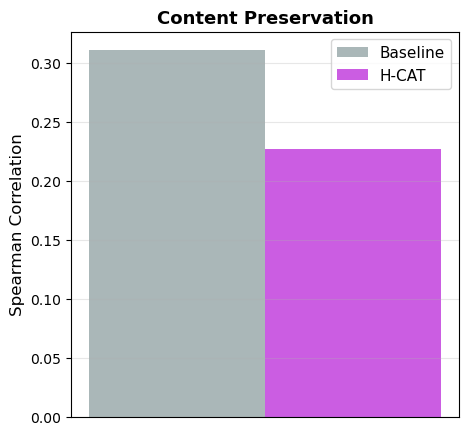

In [13]:
baseline_spearman = content_results['baseline']['spearman_correlation']
finetuned_spearman = content_results['finetuned']['spearman_correlation']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = np.arange(1)
width = 0.35

baseline_prec = [baseline_spearman]
finetuned_prec = [finetuned_spearman]

bars1 = ax.bar(x - width/2, baseline_prec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_prec, width, label='H-CAT', alpha=0.8, color='#bf34db')

# ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Spearman Correlation', fontsize=12)
ax.set_title('Content Preservation', fontsize=13, fontweight='bold')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# ax.set_xticks(x)
# ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)


GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Building NetworkKit graph...
Graph has 14384 nodes and 111873 edges
Test nodes with embeddings and in graph: 1439

Sampling node pairs (strategy: stratified)...
Sampling from 1439 test nodes...


Stratified sampling:   0%|          | 0/1439 [00:00<?, ?it/s]

Sampled 132074 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/1439 [00:00<?, ?it/s]

Pairs with finite graph distance: 132074

Computing embedding distances (metric: cosine)...

Final pair count: 132074

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.7937 (p=0.0000e+00)
  Pearson correlation: 0.7758 (p=0.0000e+00)

Distance Distribution:
  Distance 1: 11807 pairs, mean emb dist = 0.0101 ± 0.1140
  Distance 2: 14567 pairs, mean emb dist = 0.0150 ± 0.1393
  Distance 3: 14619 pairs, mean emb dist = 0.0230 ± 0.1718
  Distance 4: 14619 pairs, mean emb dist = 0.0705 ± 0.2960
  Distance 5: 14619 pairs, mean emb dist = 0.5317 ± 0.6484
  Distance 6: 14619 pairs, mean emb dist = 1.1037 ± 0.4937
  Distance 7: 14619 pairs, mean emb dist = 1.2538 ± 0.3103
  Distance 8: 14537 pairs, mean emb dist = 1.2426 ± 0.3397
  Distance 9: 12988 pairs, mean emb dist = 1.2281 ± 0.3634
  Distance 10: 5080 pairs, mean emb dist = 1.2337 ± 0.3327



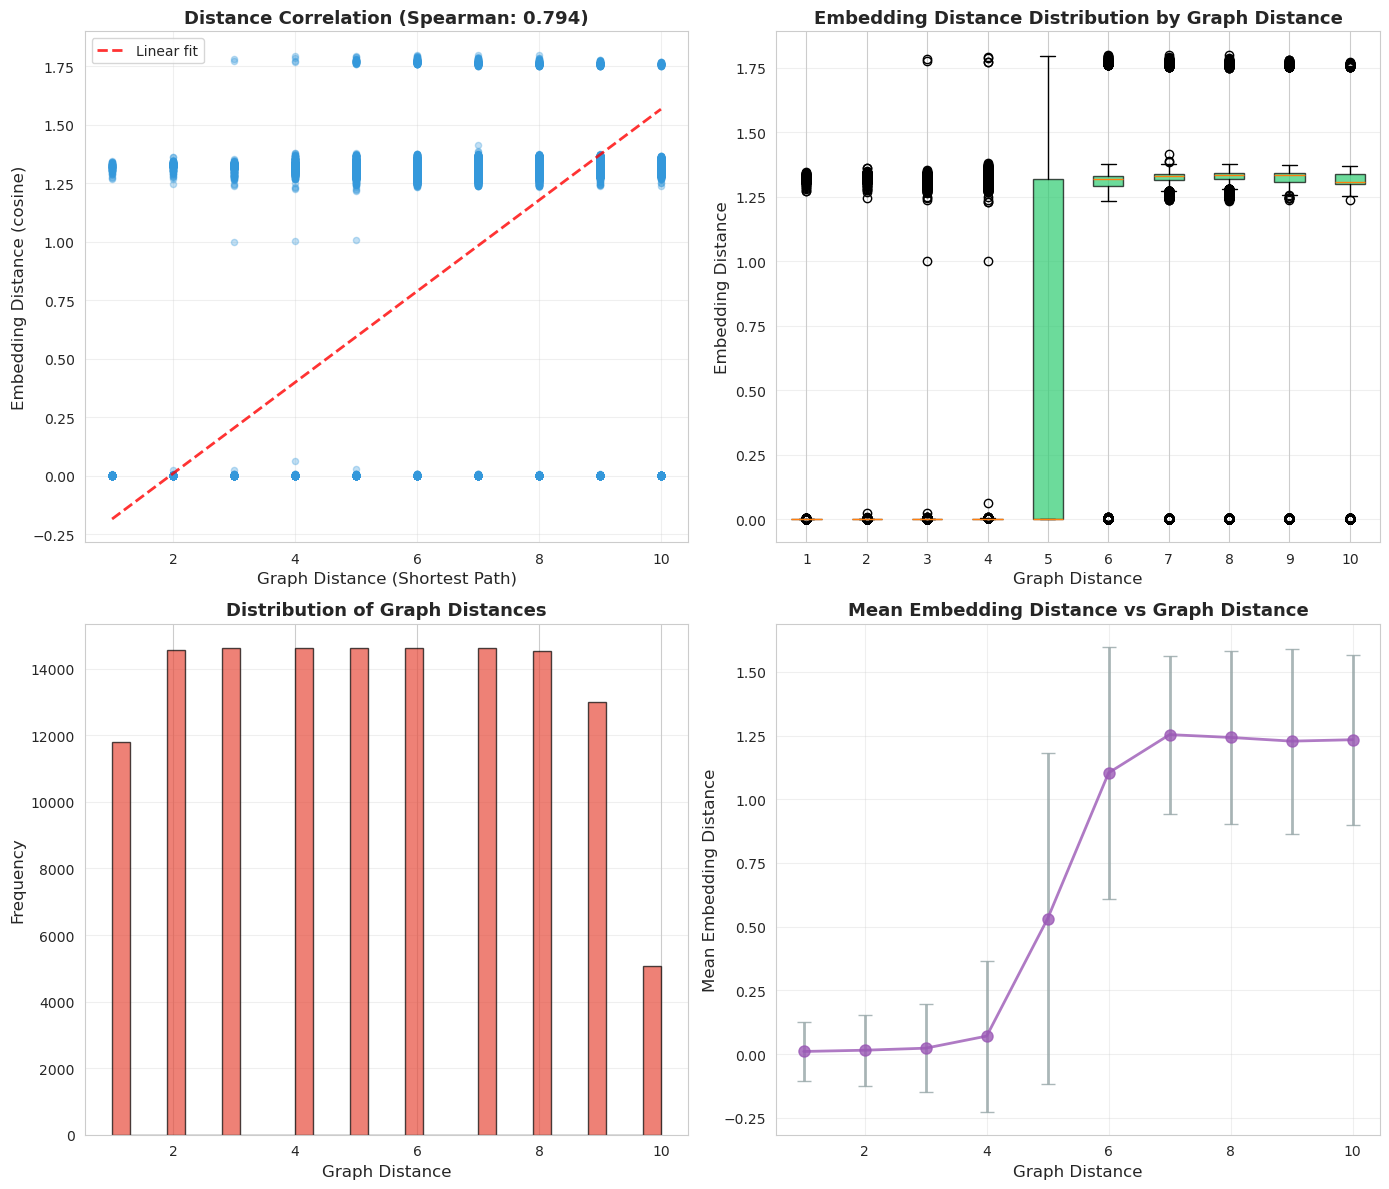

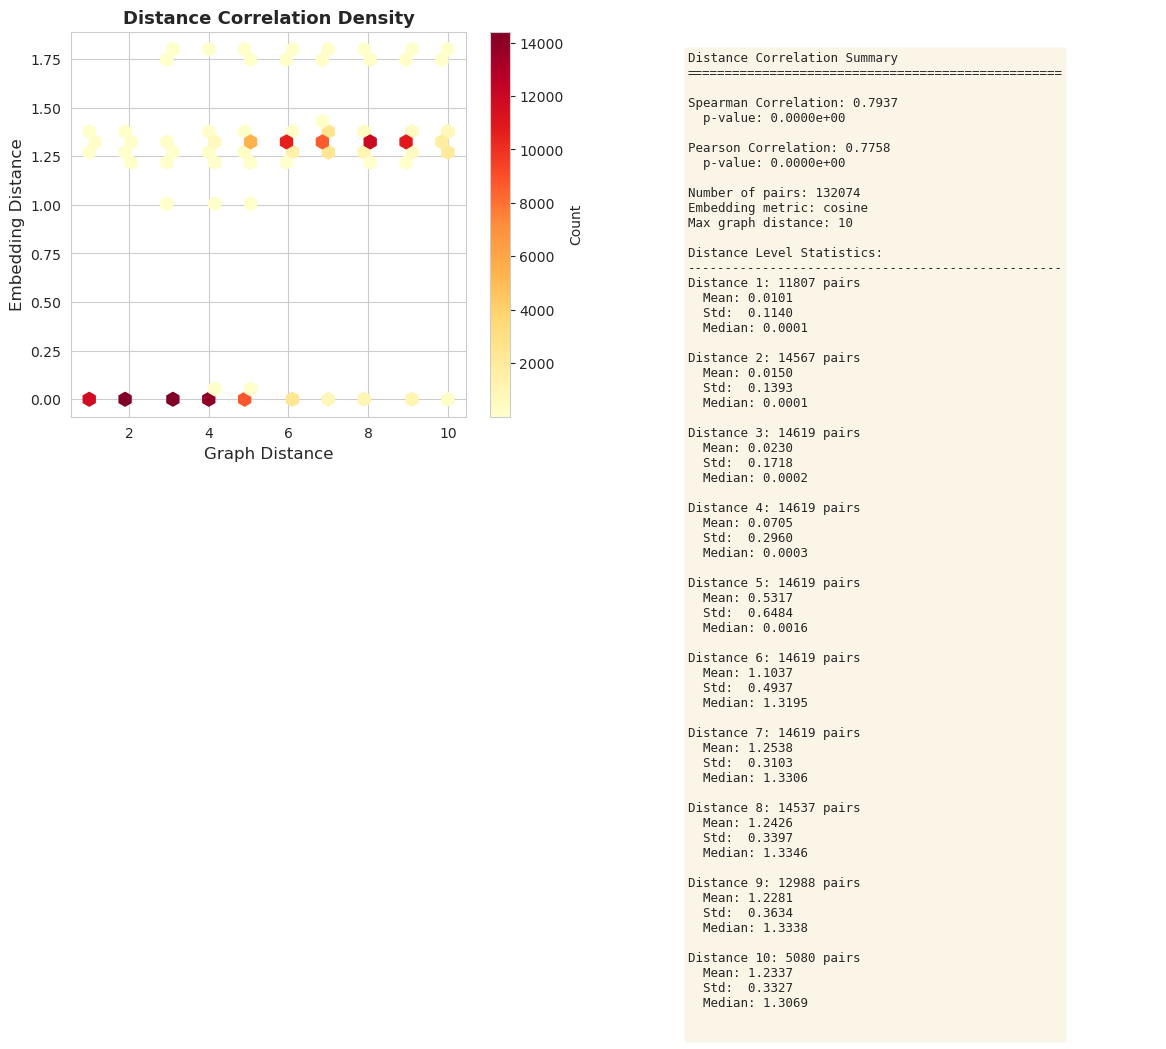

In [24]:
from utils.evaluation.graph_dist_eval import evaluate_distance_correlation, plot_distance_correlation

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Just like link_prediction.py
finetuned_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=embeddings_dict,
    test_nodes=test_nodes,  # List of node IDs to evaluate
    num_samples_per_node=100,     # Sample 100 pairs per test node
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'  # or 'random'
)

plot_distance_correlation(finetuned_distance_evaluation)


GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Building NetworkKit graph...
Graph has 14384 nodes and 111873 edges
Test nodes with embeddings and in graph: 1439

Sampling node pairs (strategy: stratified)...
Sampling from 1439 test nodes...


Stratified sampling:   0%|          | 0/1439 [00:00<?, ?it/s]

Sampled 132074 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/1439 [00:00<?, ?it/s]

Pairs with finite graph distance: 132074

Computing embedding distances (metric: cosine)...

Final pair count: 132074

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.3928 (p=0.0000e+00)
  Pearson correlation: 0.3796 (p=0.0000e+00)

Distance Distribution:
  Distance 1: 11807 pairs, mean emb dist = 0.2516 ± 0.1092
  Distance 2: 14567 pairs, mean emb dist = 0.2547 ± 0.1002
  Distance 3: 14619 pairs, mean emb dist = 0.2681 ± 0.1009
  Distance 4: 14619 pairs, mean emb dist = 0.2915 ± 0.1009
  Distance 5: 14619 pairs, mean emb dist = 0.3238 ± 0.0946
  Distance 6: 14619 pairs, mean emb dist = 0.3404 ± 0.0850
  Distance 7: 14619 pairs, mean emb dist = 0.3503 ± 0.0829
  Distance 8: 14537 pairs, mean emb dist = 0.3538 ± 0.0834
  Distance 9: 12988 pairs, mean emb dist = 0.3556 ± 0.0854
  Distance 10: 5080 pairs, mean emb dist = 0.3510 ± 0.0907



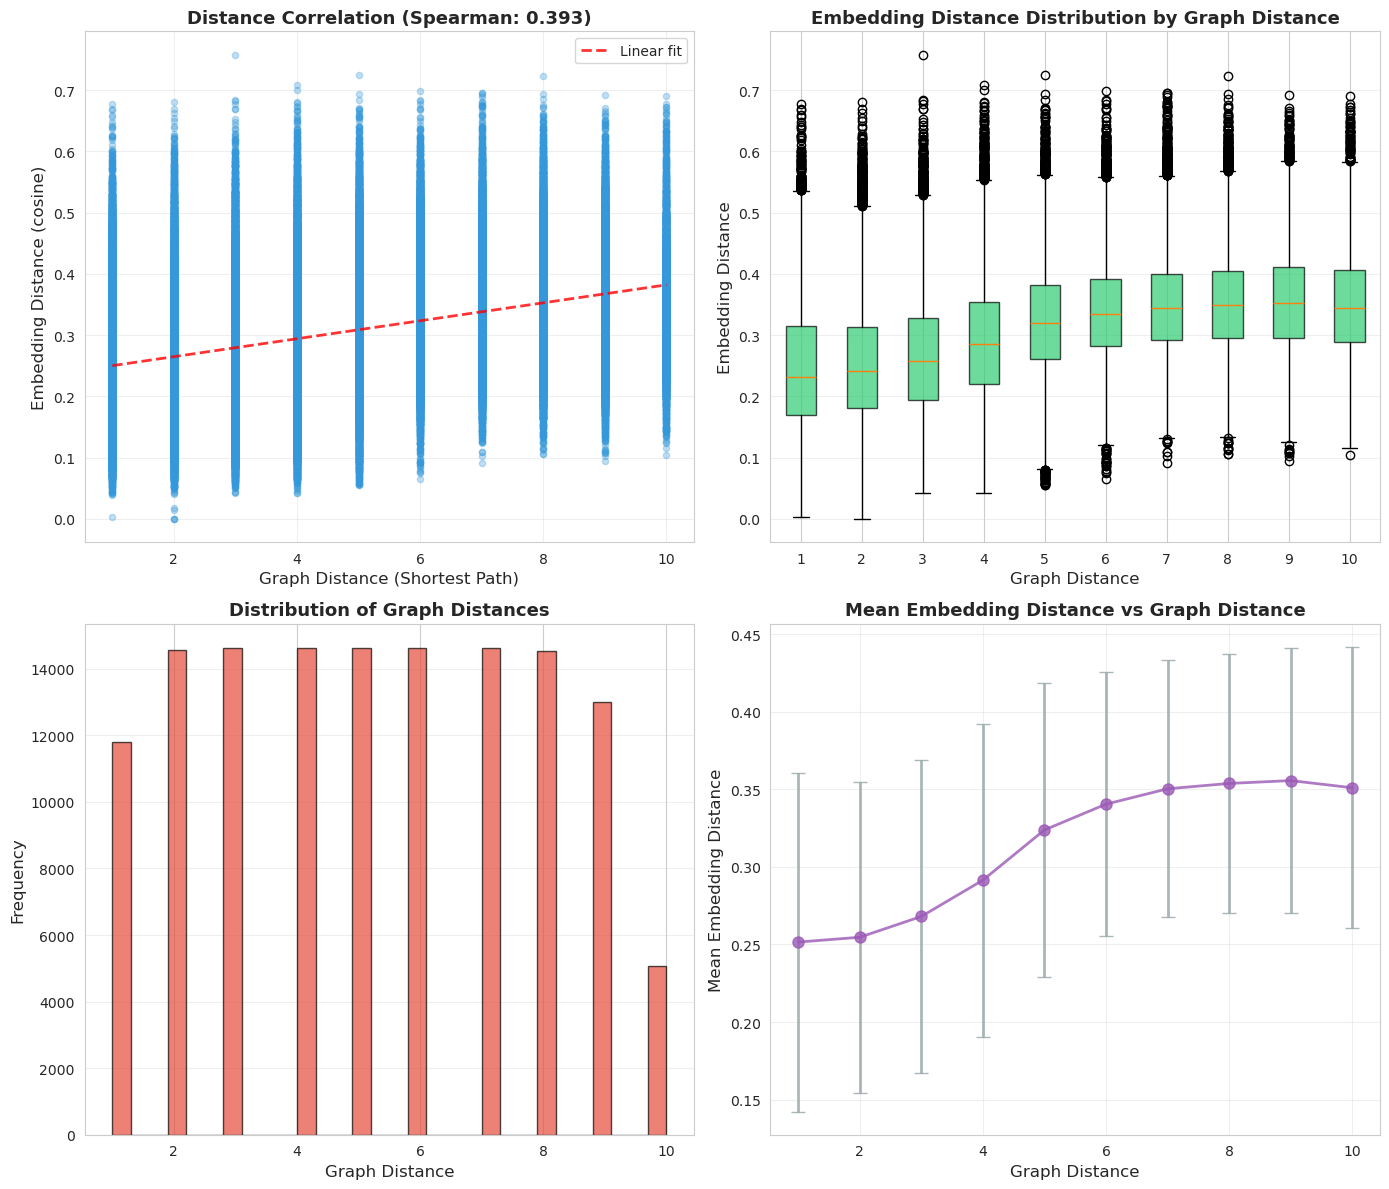

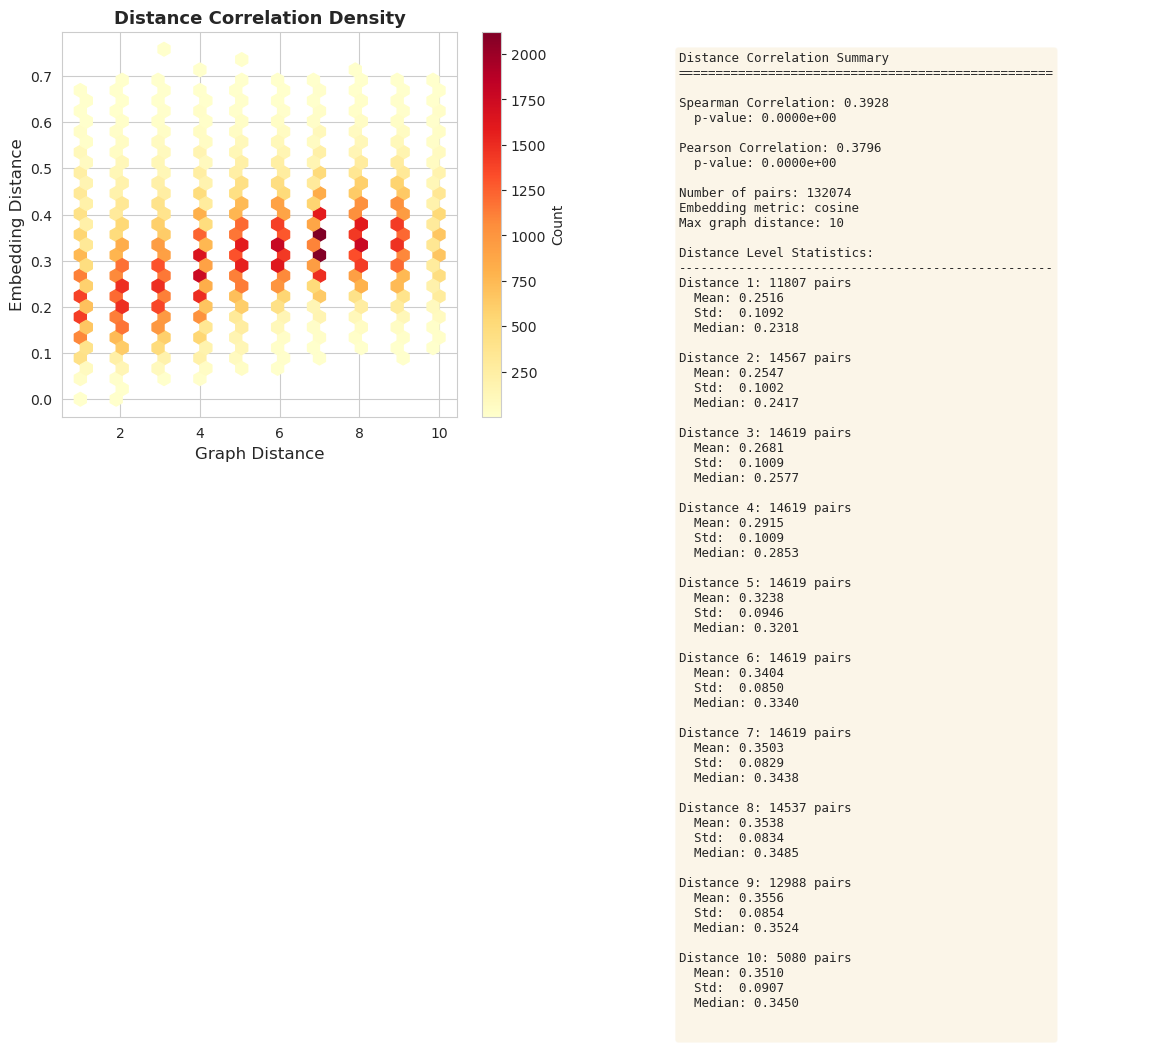

In [25]:
# Just like link_prediction.py
baseline_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_nodes,  # List of node IDs to evaluate
    num_samples_per_node=100,     # Sample 100 pairs per test node
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'  # or 'random'
)

plot_distance_correlation(baseline_distance_evaluation)

In [18]:
results_dir = BASE_DIR / "cat-hcat" / "hcat" / "experiments" / "results"

with open(results_dir / "content_results.json", 'w') as f:
    json.dump(content_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [19]:
with open(results_dir / "finetuned_tree_results.json", 'w') as f:
    json.dump(finetuned_tree_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [20]:
with open(results_dir / "baseline_tree_results.json", 'w') as f:
    json.dump(baseline_tree_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [29]:
with open(results_dir / "baseline_distance_results.json", 'w') as f:
    json.dump(baseline_distance_evaluation, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [30]:
with open(results_dir / "finetuned_distance_results.json", 'w') as f:
    json.dump(finetuned_distance_evaluation, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)